# Asteroids plot
2019.10.21
Revisiting problem from GTOC 4 - Asteroids Billiard
https://sophia.estec.esa.int/gtoc_portal/?page_id=23

Preliminary visualization of asteroids position

In [17]:
import numpy as np
import pandas as pd
import spiceypy as spice
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
import plotly.express as px


In [18]:
# load spice kernels
spice.furnsh('../spice/naif0012.tls')

In [19]:
# define function to create circle
def mycircle(x0,y0,r,points=100):
    """Function creates array of points to plot a 2D circle. Requires numpy package. 
    Args:
        x0 (float): x-coordinate of circle
        y0 (float): y-coordinate of circle
        r (float): radius
        points (int): number of points used to create circle
    Returns:
        (numpy array): points x 2 numpy array of coordinates of circle
    """
    # initialize array
    coord = np.zeros((points,2))
    # polar definition of circle
    theta = np.linspace(0, 2*np.pi, num=points)
    for i in range(points):
        coord[i,0] = r * np.sin(theta[i])
        coord[i,1] = r * np.cos(theta[i])
    
    return coord

In [20]:
# import ephemerides data from GTOC4 into pandas dataframe
elmnts = ['Name','Epoch','a','e','i','LAN','periap','theta']
df = pd.read_fwf('../gtoc4_problem_data.txt', sep='\t', skiprows=1)
num,tmp = df.shape
print(df.shape)
df.head(5)

(1436, 8)


,# Name,Epoch (MJD),a (AU),e,i (deg),LAN (deg),arg. periap. (deg),mean anomaly (deg)
0,'1580',54800.0,2.196803,0.487683,52.090794,62.324795,159.539839,3.521687
1,'1620',54800.0,1.245551,0.335511,13.337693,337.266017,276.806539,136.950031
2,'1943',54800.0,1.430317,0.255816,8.704065,246.401915,338.253875,288.405238
3,'2061',54800.0,2.264953,0.537119,3.770822,207.654108,156.432028,46.995497
4,'2135',54800.0,1.599572,0.503268,23.054312,191.262849,290.838892,256.724981


In [21]:
# reassign column names
df.columns =  ['Name','Epoch','a','e','i','LAN','omega','M0']
df.head(3)

,Name,Epoch,a,e,i,LAN,omega,M0
0,'1580',54800.0,2.196803,0.487683,52.090794,62.324795,159.539839,3.521687
1,'1620',54800.0,1.245551,0.335511,13.337693,337.266017,276.806539,136.950031
2,'1943',54800.0,1.430317,0.255816,8.704065,246.401915,338.253875,288.405238


### Preliminary visualization 
(validation of imported data)

In [22]:
# define gravitational parameters
MU = 1.32712440018*10**11   # sun's gravitational parameter [km^3/s^2]
AU = 1.49597870691*10**8    # astronomical unit [AU] to [km]
g0 = 9.80665                # gravitational acceleration [m/s^2]

# time to compute orbit position
JD = df.at[0,'Epoch'] + 2400000.5  # convert Modified Julian Date to Julian Date
strtime = str(JD) + ' JD'
et0 = spice.str2et(strtime)         # convert Julian Date to ephemeris seconds
print('State vector computed at: {}'.format(spice.et2utc(et0,'C',1)))

# compute initial state vector of asteroids
sv = np.zeros((6,num)) # initialize

for i in range(num):    
    rp = df.at[i,'a'] * (1 - df.at[i,'e'])
    elts = [rp, df.at[i,'e'], np.rad2deg(df.at[i,'i']), np.rad2deg(df.at[i,'LAN']), np.rad2deg(df.at[i,'omega']), np.rad2deg(df.at[i,'M0']), et0, MU]
    tmp = spice.conics(elts,et0)
    # store position
    sv[0,i] = tmp[0]  # x-position
    sv[1,i] = tmp[1]  # y-position
    sv[2,i] = tmp[2]  # z-position
    # store velocity
    sv[3,i] = tmp[3]  # x-velocity
    sv[4,i] = tmp[4]  # y-velocity
    sv[5,i] = tmp[5]  # z-velocity
    
# also define colors, size
sizasterpod = 0.001 * np.ones(num)

# convert to tidy pandas dataframe
pos0_ast = pd.DataFrame({"x" : sv[0,:],
                       "y" : sv[1,:],
                       "z" : sv[2,:],
                       "vx" : sv[3,:],
                       "vy" : sv[4,:],
                       "vz" : sv[5,:],
                       "size" : sizasterpod})

pos0_ast

State vector computed at: 2008 NOV 30 00:00:00.0


,x,y,z,vx,vy,vz,size
0,-1.606422,0.746005,0.070591,-234898.281505,-183642.865573,20600.539689,0.001
1,-0.947496,-0.466386,0.483588,-96845.316244,237839.994675,-236684.758079,0.001
2,-1.008135,0.085266,0.453092,-33163.991506,291754.590341,-245818.579483,0.001
3,-3.092219,-1.546555,0.087063,-28360.876022,98481.044613,87457.961697,0.001
4,-0.261305,-0.065627,0.899816,-349175.509765,-277537.057247,25771.504189,0.001
...,...,...,...,...,...,...,...
1431,-0.440726,-0.600665,-1.083273,-181781.721619,-176335.463255,202467.919313,0.001
1432,1.022255,-0.305983,-0.396717,46718.990927,366167.916183,59062.174169,0.001
1433,0.023518,-0.818000,-1.311914,-287655.707045,170547.853476,106793.673341,0.001
1434,0.480878,0.016169,0.791056,318531.705930,-175567.610972,-175480.687413,0.001


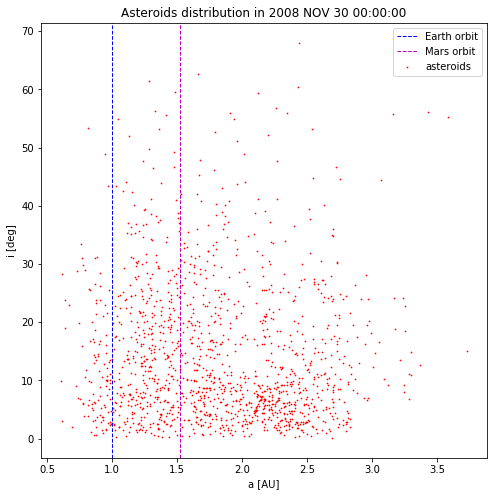

In [23]:
# plot statistical data of asteroids: inclination vs. semi-major axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
x = np.zeros(num)
y = np.zeros(num)
for i in range(num):
    x[i] = df.at[i,'a']
    y[i] = df.at[i,'i']
    
plt.scatter(x, y, label='asteroids', c='r', s=0.5)
plt.axvline(x=1, label='Earth orbit',ls='--',lw=1,c='b')
plt.axvline(x=1.52, label='Mars orbit',ls='--',lw=1,c='m')

plt.title(f'Asteroids distribution in {spice.et2utc(et0,"c",0)}')
plt.xlabel('a [AU]')
plt.ylabel('i [deg]')
plt.legend()
plt.show()

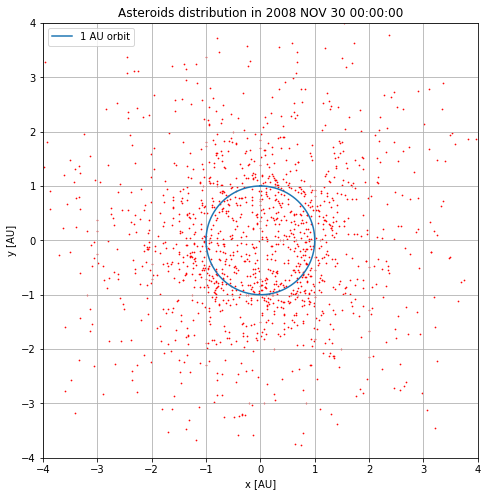

In [24]:
# plot statistical data of asteroids: orbit in x-y plane
fig = plt.figure(figsize=(8, 8))

x = np.zeros(num)
y = np.zeros(num)
for i in range(num):
    x[i] = pos0_ast.at[i,'x']
    y[i] = pos0_ast.at[i,'y']
    
    xx = pos0_ast.at[i,'x']
    yy = pos0_ast.at[i,'y']
    plt.scatter(xx, yy, c='r', s=0.5)

# create circle to represent Earth
circle_coord = mycircle(0,0,1)
plt.plot(circle_coord[:,0], circle_coord[:,1], label='1 AU orbit')

# formating plot
#plt.scatter(x, y, label='asteroids', c='r', s=0.5)
#plt.axvline(x=0, ls='--',lw=0.3, c='k')
#plt.axhline(y=0, ls='--',lw=0.3, c='k')
plt.grid()
plt.title(f'Asteroids distribution in {spice.et2utc(et0,"c",0)}')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.axis('scaled')
plt.legend()
plt.ylim(-4, 4)
plt.xlim(-4, 4)
plt.show()



In [25]:
# Earth ephemeris
def Earth(param):
    """Function returns ephemeris value prompted, as defined by GTOC4 problem statement
    Args:
        param (str): orbital parameter to be fetched
            a: semi-major axis [AU]
            e: eccentricity
            i: inclination [deg]
            LAN: longitude of ascendig node [deg]
            omega: argument of periapsis [deg]
            M0: mean anomaly [deg]
            t: Epoch at which these elements are defined [MJD]
    Returns:
        (float): value of prompted parameter
    """
    if param == 'a':
        retval = 0.999988049532578
    elif param == 'e':
        retval = 1.671681163160 / np.power(10,2)
    elif param == 'i':
        retval = 0.8854353079654 / np.power(10,3)
    elif param == 'LAN':
        retval = 175.40647696473
    elif param == 'omega':
        retval = 287.61577546182
    elif param == 'M0':
        retval = 257.60683707535
    elif param == 't':
        retval = 54000
    else:
        print('function parameter is invalid')
        return None
    return retval


In [26]:
# compute Earth position
rp = Earth('a') * (1 - Earth('e'))
elts = [rp, Earth('e'), np.rad2deg(Earth('i')), np.rad2deg(Earth('LAN')), np.rad2deg(Earth('omega')), np.rad2deg(Earth('M0')), et0, MU]
Earth0 = spice.conics(elts,et0)


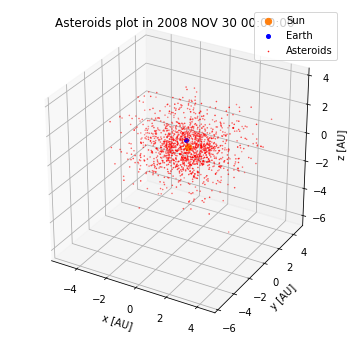

In [27]:
# plot 3D asteroid positions at one instance in time
#%matplotlib
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0,0,0, c='tab:orange', label='Sun',s=40)
ax.scatter(Earth0[0],Earth0[1],Earth0[2], c='b', label='Earth',s=16)
ax.scatter(sv[0,:], sv[1,:], sv[2,:], c='r', s=0.3, label='Asteroids')

plt.title(f'Asteroids plot in {spice.et2utc(et0,"c",0)}')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.legend()
plt.show()


In [28]:
# 3D plotly orbit of asteroids
fig = px.scatter_3d(pos0_ast, x='x', y='y', z='z', size='size')
fig.show()

### Orbit Propagation over time range of interest

In [29]:
# Setup for orbit propagation
step = 1000
# start and end time (end time includes +10 years for operation)
utc = ['Jan 1, 2015','Dec 31, 2035']
etOne = spice.str2et(utc[0])  # convert to ephemeris seconds
etTwo = spice.str2et(utc[1])  # convert to ephemeris seconds
print("ET One: {}, ET Two: {}".format(etOne, etTwo))

# get times between start and end
etRange = [x*(etTwo-etOne)/step + etOne for x in range(step)]
    

ET One: 473342467.18391585, ET Two: 1135944069.183874


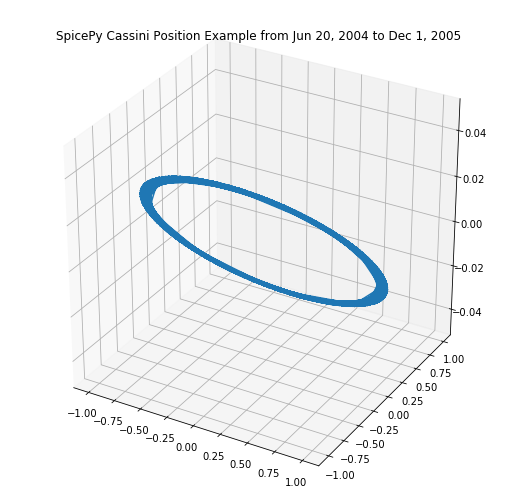

In [35]:
# Earth orbit propagation
# initialize state-vector matrix
sv_prop_Earth = np.zeros((6,step))

for i in range(step):
    elts = [rp, Earth('e'), np.rad2deg(Earth('i')), np.rad2deg(Earth('LAN')), np.rad2deg(Earth('omega')), np.rad2deg(Earth('M0')), et0, MU]
    tmp = spice.conics(elts,etRange[i]) # propagate state vector of Earth
    # store position
    sv_prop_Earth[0,i] = tmp[0]  # x-position
    sv_prop_Earth[1,i] = tmp[1]  # y-position
    sv_prop_Earth[2,i] = tmp[2]  # z-position
    # store velocity
    sv_prop_Earth[3,i] = tmp[3]  # x-velocity
    sv_prop_Earth[4,i] = tmp[4]  # y-velocity
    sv_prop_Earth[5,i] = tmp[5]  # z-velocity

# plot propagated orbit
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.plot(sv_prop_Earth[0], sv_prop_Earth[1], sv_prop_Earth[2])
plt.title('SpicePy Cassini Position Example from Jun 20, 2004 to Dec 1, 2005')
plt.show()


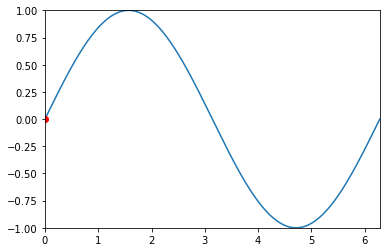

In [31]:
TWOPI = 2*np.pi

fig, ax = plt.subplots()

t = np.arange(0.0, TWOPI, 0.001)
s = np.sin(t)
l = plt.plot(t, s)

ax = plt.axis([0,TWOPI,-1,1])

redDot, = plt.plot([0], [np.sin(0)], 'ro')

def animate(i):
    redDot.set_data(i, np.sin(i))
    return redDot,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(0.0, TWOPI, 0.1),interval=10, blit=True, repeat=True)

plt.show()


In [32]:
# Tisserand's parameter
# https://en.wikipedia.org/wiki/Tisserand%27s_parameter